In [6]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from mprompt.modules.fmri_module import SAVE_DIR_FMRI
import imodelsx.util
from mprompt.modules.emb_diff_module import EmbDiffModule
import scipy.stats
from mprompt.methods.m4_evaluate import D5_Validator
import torch.cuda
num_top_test_ngrams = 75
# r = (pd.read_pickle('../results/results_fmri.pkl')
    # .sort_values(by=['top_score_synthetic'], ascending=False))
r = (pd.read_pickle('../results/results_fmri_full.pkl')
    .sort_values(by=['top_score_synthetic'], ascending=False))
# r = r[r.subject == 'UTS02']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
columns = {
    # fmri stuff
    'subject': 'Subject',
    'module_num': 'Voxel',
    'roi_func': 'ROI (functional)',
    'roi_anat': 'ROI (anatomical)',
    'fmri_test_corr': 'Correlation (test)',
    
    # scores
    'top_score_synthetic': 'Synthetic data score',
    'frac_top_ngrams_module_correct': 'Fraction of matching ngrams (module, top-75)',
    'rankcorr_expl_test': 'Correlation (test) when predicting with only explanation',
    # 'frac_top_ngrams_test_correct': 'Fraction of matching ngrams (test, top-75)',
            
    # explanation
    'top_explanation_init_strs': 'Explanation',
        
    # ngrams matching the explanation (used 75 ngrams)
    'top_ngrams_module_correct': 'Matching top ngrams (out of top-75)',
    # 'top_ngrams_test_correct': 'Matching ngrams (test, top-75)',

    # all ngrams
    'top_ngrams_module_25': 'All top ngrams (top-25)',
    # 'top_ngrams_test_25': 'Top ngrams (test, top-25)',

    # alternative explanations
    'explanation_init_strs': 'Explanation candidates',
}

tab = (
    r
    .sort_values(by=['top_score_synthetic'], ascending=False)
    # .sort_values(by=['rankcorr_expl_test'], ascending=False)
    .filter(columns.keys())
    .rename(columns=columns)
    .round(3)
)
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    display(
        tab.head(3)
    )
    tab_join_lists = tab.applymap(lambda x: ' __ '.join(x) if isinstance(x, np.ndarray) or isinstance(x, list) else x)
    tab_join_lists.to_csv('../results/results_fmri.csv', index=False, float_format='%.3f')

,Subject,Voxel,ROI (functional),ROI (anatomical),Correlation (test),Synthetic data score,"Fraction of matching ngrams (module, top-75)",Correlation (test) when predicting with only explanation,Explanation,Matching top ngrams (out of top-75),All top ngrams (top-25),Explanation candidates
725,UTS02,220,[ATFP],[parstriangularis],0.545,0.249,0.640,-0.015,"physical actions, such as cutting, slapping, taping, and inhaling","[throat was slit, gargling, hugged them inhaling, snapped his neck, couple hard thwacks, inhaling, knife and slit, seal meat, taping their wounds, scrubbing pans angrily, karate chopped, bits of flesh, abdominal thrusts, dumps raw sewage, kicking sand, tapping the fabric, shave their, have thinly sliced, finger his, thinly sliced, four broken ribs, crushing my rib, a hard slap, duct taping their, hard thwacks, clench my jaw, stripped and spit, fill our lungs, slit that neck, gargling for, spit on, cook the tenderloin, hard slap and, the vice grip, gaffers tape, scrubbing pans, smite their brows, slapping his behind, shake chile powder, they gaffers tape, nose is bleeding, buttered slices, fists clutching, gagging and drooling, mother put sausages, scalp wounds, spitting, taping their burns]","[throat was slit, gargling, hugged them inhaling, snapped his neck, half inch chunks, couple hard thwacks, inhaling, knife and slit, seal meat, taping their wounds, lob rhetorical grenades, scrubbing pans angrily, karate chopped, cucumber and mayonnaise, fifty percent sawdust, bits of flesh, sugar cubes delicately, abdominal thrusts, dumps raw sewage, kicking sand, dry heaving, tapping the fabric, a ritalin drip, shave their, have thinly sliced]","[physical actions, such as cutting, slapping, taping, and inhaling, physical action, physical actions, physical violence or injury, physical violence or aggression]"
999,UTS02,449,"[pSTS, ATFP]",[middletemporal],0.464,0.210,0.733,0.065,"language, either in the form of words, phrases, slogans, mottos, or metaphors","[seventh grade slurs, naming the phenomenon, scientific name for, ithe school motto, the word contractions, adopted this vocabulary, like creationist biology, writing his obituary, a euphemism, new advertising slogan, the terrible disease, the common refrain, kitchen nickname, euphemism for, to ethnically stereotype, figurative language, 's company tagline, this a stillbirth, creationist biology, remember this mantra, was his mantra, called the unboyfriend, mottoes and catchphrases, again this mantra, our vows unimpeachable, 's first commandment, resonant as metaphor, of flirty banter, game 's tagline, couched in terms, conception unnatural, modern computer terminology, advertising slogan diet, care a euphemism, first kitchen nickname, park your attitudinal, dialing the unboyfriend, nasa mission statement, snide comment, the founding document, to the anthropocene, crop the paradigmatic, call my president, our official religion, its scientific name, three month prognosis, theater slogan, read social cues, biologically monotonous, first commandment, the unboyfriend, boyish almost biblical, new mission statement, this big machismo, a scientific name]","[area codes pseudonyms, personality any diagnosis, seventh grade slurs, naming the phenomenon, notes sounded aerobic, scientific name for, ithe school motto, the word contractions, dictate her geography, adopted this vocabulary, like creationist biology, catalysts like jaywalking, writing his obituary, like the anthropocene, a euphemism, named for tetraminoes, new advertising slogan, the terrible disease, the common refrain, kitchen nickname, euphemism for, to ethnically stereotype, figurative language, 's company tagline, terms of production]","[language, either in the form of words, phrases, slogans, mottos, or metaphors, language, either in terms of words, phrases, or slogans, phrases, words, or concepts, phrases or terms related to language, communication, and/or culture, language, either in terms of words, phrases, or ex

In [4]:
dsets = joblib.load(join(SAVE_DIR_FMRI, 'stories', 'running_words.jbl'))

for i in tqdm(range(1)):
    row = r.iloc[i]
    resp = dsets[row['subject']]['resp'][:, row['module_num']]
    neg_dists = row['neg_dists_expl_test']

100%|██████████| 1/1 [00:00<00:00, 1746.17it/s]


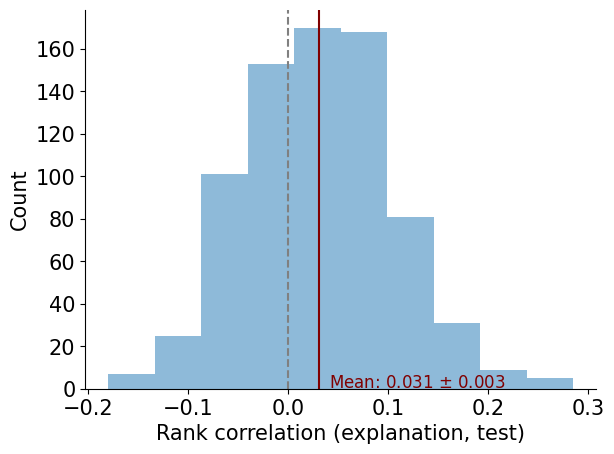

In [5]:
plt.hist(r['rankcorr_expl_test'], alpha=0.5) #, bins=20)
plt.axvline(0, color='gray', linestyle='dashed')
plt.ylabel('Count')

# draw vertical line at mean and add text label
plt.axvline(r['rankcorr_expl_test'].mean(), color='maroon')
mean_and_std_err_string = f"Mean: {r['rankcorr_expl_test'].mean():.3f} $\pm$ {r['rankcorr_expl_test'].std() / np.sqrt(r['rankcorr_expl_test'].size):.3f}"
plt.text(r['rankcorr_expl_test'].mean() + 0.01, 0.5, mean_and_std_err_string, rotation=0, fontsize=12, color='maroon')
plt.xlabel('Rank correlation (explanation, test)')
plt.show()

# with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
#     display(
#         r.sort_values(by=['rankcorr_expl_test'], ascending=False)[['top_explanation_init_strs', 'rankcorr_expl_test', 'roi_func', 'fmri_test_corr', 'subject']].head(20)
#     )

### Visualize how things relate to each other

In [ ]:
scores = ['fmri_test_corr', 'top_score_synthetic', 'frac_top_ngrams_module_correct', 'rankcorr_expl_test']
sns.pairplot(
    r[scores], kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.1}}, markers='.',
    height=3, aspect=2,
    corner=True
    )
plt.show()